<H1> Segmenting, Clustering and Recommending to avoid bad choice of Neighborhoods for New Restaurants in Toronto
    

<H2> 1. Install & Import Libraries

In [1]:
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.4.0               |             py_0          26 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    ------------------------------------------------------------
                       

In [2]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans


import matplotlib.pyplot as plt
import seaborn as sns
import folium # map rendering library



import types
from botocore.client import Config
import ibm_boto3

print('Libraries imported.')

Libraries imported.


<H2> 2. Read html using BeautifulSoup library

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M';
html = requests.get(url).text
soup = BeautifulSoup(html,'lxml')

In [4]:
# find the table
postal_codes_table = soup.find('table',{'class':'wikitable sortable'})

In [5]:
# extract td's only
table_cells = postal_codes_table.find_all('td')

In [6]:
# group each 3 cells together
N = 3
table_rows = [table_cells[n:n+N] for n in range(0, len(table_cells), N)]
postal_code = []
borough = []
neighborhood = []
for row in table_rows:
    postal_code_text = row[0].text
    borough_text = row[1].text
    neighborhood_text = row[2].text.rstrip('\n')
    if borough_text != 'Not assigned':
        postal_code.append(postal_code_text)
        borough.append(borough_text)
        neighborhood.append(neighborhood_text)

<H2> 3. Create & Explore Dataset

In [7]:
df = pd.DataFrame()
df['PostalCode'] = postal_code
df['Borough'] = borough
df['Neighborhood'] = neighborhood
df.head()

,PostalCode,Borough,Neighborhood
0,M1A\n,Not assigned\n,
1,M2A\n,Not assigned\n,
2,M3A\n,North York\n,Parkwoods
3,M4A\n,North York\n,Victoria Village
4,M5A\n,Downtown Toronto\n,Regent Park / Harbourfront


In [8]:
df['PostalCode']=df['PostalCode'].str[:3]
df['Borough']=df['Borough'].replace("Central Toronto\n", "Central Toronto")
df['Borough']=df['Borough'].replace("Downtown Toronto\n", "Downtown Toronto")
df['Borough']=df['Borough'].replace("East Toronto\n", "East Toronto")
df['Borough']=df['Borough'].replace("East York\n", "East York")
df['Borough']=df['Borough'].replace("Etobicoke\n", "Etobicoke")
df['Borough']=df['Borough'].replace("Mississauga\n", "Mississauga")
df['Borough']=df['Borough'].replace("North York\n", "North York")
df['Borough']=df['Borough'].replace("Not assigned\n", "Not assigned")
df['Borough']=df['Borough'].replace("Scarborough\n", "Scarborough")
df['Borough']=df['Borough'].replace("West Toronto\n", "West Toronto")
df['Borough']=df['Borough'].replace("York\n", "York")

In [9]:
# group neighborhoods of the same postal code
df = df.groupby(['PostalCode','Borough']).aggregate(lambda x : ', '.join(x)).reset_index()
df.head(20)

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,
1,M1B,Scarborough,Malvern / Rouge
2,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek
3,M1E,Scarborough,Guildwood / Morningside / West Hill
4,M1G,Scarborough,Woburn
5,M1H,Scarborough,Cedarbrae
6,M1J,Scarborough,Scarborough Village
7,M1K,Scarborough,Kennedy Park / Ionview / East Birchmount Park
8,M1L,Scarborough,Golden Mile / Clairlea / Oakridge
9,M1M,Scarborough,Cliffside / Cliffcrest / Scarborough Village West


In [10]:
# check M5A 
df.loc[df['PostalCode'] == 'M5A']

,PostalCode,Borough,Neighborhood
80,M5A,Downtown Toronto,Regent Park / Harbourfront


In [11]:
# fill 'Not assigned' neighborhood to the proper borough
df.loc[df['Neighborhood'] == 'Not assigned', 'Neighborhood'] = df['Borough']

In [12]:
# check M5A 
df.loc[df['PostalCode'] == 'M7A']

,PostalCode,Borough,Neighborhood
120,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


In [13]:
# df shape
df.shape

(180, 3)

<H2> Insert Geospatial Coordinates CSV file to the code

In [14]:
def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_1f2743066d6b4a08862baaf50b794f6d = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='DaADxXD1xYXv4gPZuq9gM2enGDBpOTc_pftcgowbyk-C',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_1f2743066d6b4a08862baaf50b794f6d.get_object(Bucket='mydatascienceproject-donotdelete-pr-4no7swxe9h5vwt',Key='Geospatial_Coordinates.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


<H2> Perform Left Join to the data frames.

In [15]:
df_data_1.rename(columns={'Postal Code':'PostalCode'},inplace=True)
df_data_1.head()
df = pd.merge(df, df_data_1, on='PostalCode', how='left')
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1A,Not assigned,,NaN,NaN
1,M1B,Scarborough,Malvern / Rouge,43.806686,-79.194353
2,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497
3,M1E,Scarborough,Guildwood / Morningside / West Hill,43.763573,-79.188711
4,M1G,Scarborough,Woburn,43.770992,-79.216917


In [16]:
# check M5G 
df.loc[df['PostalCode'] == 'M1A']

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1A,Not assigned,,NaN,NaN


In [17]:
df = df[df.Borough != "Not assigned"]
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
1,M1B,Scarborough,Malvern / Rouge,43.806686,-79.194353
2,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497
3,M1E,Scarborough,Guildwood / Morningside / West Hill,43.763573,-79.188711
4,M1G,Scarborough,Woburn,43.770992,-79.216917
5,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


<H2> Now let's create a map of Toronto with neighborhoods superimposed on top.

first, let's work with only borough that containts the name Toronto

In [18]:
#df = df[df['Borough'].str.contains("Toronto")].reset_index()
#df.head()

In [19]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [20]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186c0',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

<H2> Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

<H2> 4. Explore Neighborhoods

Define Foursquare Credentials and Version

In [21]:
CLIENT_ID = 'G0I4SPKQGM2FAEJG1EDYF5II1BV1Q2H1ZOSTCQ33EX42FRSA' # your Foursquare ID
CLIENT_SECRET = '4AXWLB2RFP0SBNA4GLUP4TCTKGIPYF2LPRBHNCT3LVQG0SRI' # your Foursquare Secret
VERSION = '20200501' # Foursquare API version

<H3> Let's explore the first neighborhood

In [22]:
df.loc[1, 'Neighborhood']

'Malvern / Rouge'

<H4> get latitude and longitude of the neighborhood

In [23]:
neighborhood_latitude = df.loc[1, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[1, 'Longitude'] # neighborhood longitude value

neighborhood_name = df.loc[1, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Malvern / Rouge are 43.806686299999996, -79.19435340000001.


<H4> Now, let's get the top 100 venues that are within a radius of 500 meters.

In [24]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

# get resullt
results = requests.get(url).json()

In [25]:
results

{'meta': {'code': 200, 'requestId': '5eabc7c77828ae001bb75267'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Malvern',
  'headerFullLocation': 'Malvern, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 1,
  'suggestedBounds': {'ne': {'lat': 43.8111863045, 'lng': -79.18812958073042},
   'sw': {'lat': 43.80218629549999, 'lng': -79.2005772192696}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bb6b9446edc76b0d771311c',
       'name': 'Wendy’s',
       'location': {'crossStreet': 'Morningside & Sheppard',
        'lat': 43.80744841934756,
        'lng': -79.19905558052072,
        'labeledLatLngs': [{'label': 'display'

In [26]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

<H4> Now let's clean the json and structure it into a pandas dataframe.

In [27]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.id', 'venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,id,name,categories,lat,lng
0,4bb6b9446edc76b0d771311c,Wendy’s,Fast Food Restaurant,43.807448,-79.199056


<H3> Let's create a function to repeat the same process to all the neighborhoods in Toronto

In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue Id',
                  'Venue Name', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [29]:
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
1,M1B,Scarborough,Malvern / Rouge,43.806686,-79.194353
2,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497
3,M1E,Scarborough,Guildwood / Morningside / West Hill,43.763573,-79.188711
4,M1G,Scarborough,Woburn,43.770992,-79.216917
5,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [30]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'])

Malvern / Rouge
Rouge Hill / Port Union / Highland Creek
Guildwood / Morningside / West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park / Ionview / East Birchmount Park
Golden Mile / Clairlea / Oakridge
Cliffside / Cliffcrest / Scarborough Village West
Birch Cliff / Cliffside West
Dorset Park / Wexford Heights / Scarborough Town Centre
Wexford / Maryvale
Agincourt
Clarks Corners / Tam O'Shanter / Sullivan
Milliken / Agincourt North / Steeles East / L'Amoreaux East
Steeles West / L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview / Henry Farm / Oriole
Bayview Village
York Mills / Silver Hills
Willowdale / Newtonbrook
Willowdale
York Mills West
Willowdale
Parkwoods
Don Mills
Don Mills
Bathurst Manor / Wilson Heights / Downsview North
Northwood Park / York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill / Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West / Riverdale
India Bazaar / The Beaches 

In [31]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Id,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Malvern / Rouge,43.806686,-79.194353,4bb6b9446edc76b0d771311c,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497,4c23d3aaf7ced13a5ed7216d,Royal Canadian Legion,43.782533,-79.163085,Bar
2,Guildwood / Morningside / West Hill,43.763573,-79.188711,4beee041e24d20a1cd857314,RBC Royal Bank,43.766790,-79.191151,Bank
3,Guildwood / Morningside / West Hill,43.763573,-79.188711,4c62f34bde1b2d7fec89e370,G & G Electronics,43.765309,-79.191537,Electronics Store
4,Guildwood / Morningside / West Hill,43.763573,-79.188711,5411f741498e9ebd5e35d8bd,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant


In [102]:
toronto_venues.groupby('Neighborhood').count()['Venue Id']

Neighborhood
Agincourt                                                                                                                 4
Alderwood / Long Branch                                                                                                   8
Bathurst Manor / Wilson Heights / Downsview North                                                                        22
Bayview Village                                                                                                           4
Bedford Park / Lawrence Manor East                                                                                       22
Berczy Park                                                                                                              55
Birch Cliff / Cliffside West                                                                                              4
Brockton / Parkdale Village / Exhibition Place                                                                         

<H3> Let's find out how many unique categories can be curated from all the returned venues

In [32]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 262 uniques categories.


<h3> because our main goal is to recommend a neighborhood for a new restaurant, we need to filter our data, so we will have only venues categories that contains the word 'Restaurant'

In [33]:
toronto_venues = toronto_venues[toronto_venues['Venue Category'].str.contains("Restaurant")].reset_index()
toronto_venues.head()

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Id,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,0,Malvern / Rouge,43.806686,-79.194353,4bb6b9446edc76b0d771311c,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,4,Guildwood / Morningside / West Hill,43.763573,-79.188711,5411f741498e9ebd5e35d8bd,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant
2,11,Woburn,43.770992,-79.216917,4de0403ed4c040523ea079f4,Korean Grill House,43.770812,-79.214502,Korean Restaurant
3,13,Cedarbrae,43.773136,-79.239476,4b1711a6f964a520cbc123e3,Federick Restaurant,43.774697,-79.241142,Hakka Restaurant
4,14,Cedarbrae,43.773136,-79.239476,4e261f261f6eb1ae13930699,Drupati's Roti & Doubles,43.775222,-79.241678,Caribbean Restaurant


<H3>data shape

In [34]:
toronto_venues.shape

(485, 9)

let's plot veneus on the map

In [35]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [36]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name in zip(toronto_venues['Venue Latitude'], toronto_venues['Venue Longitude'] , toronto_venues['Venue Name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186c0',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

<H2> Plot Category distribution

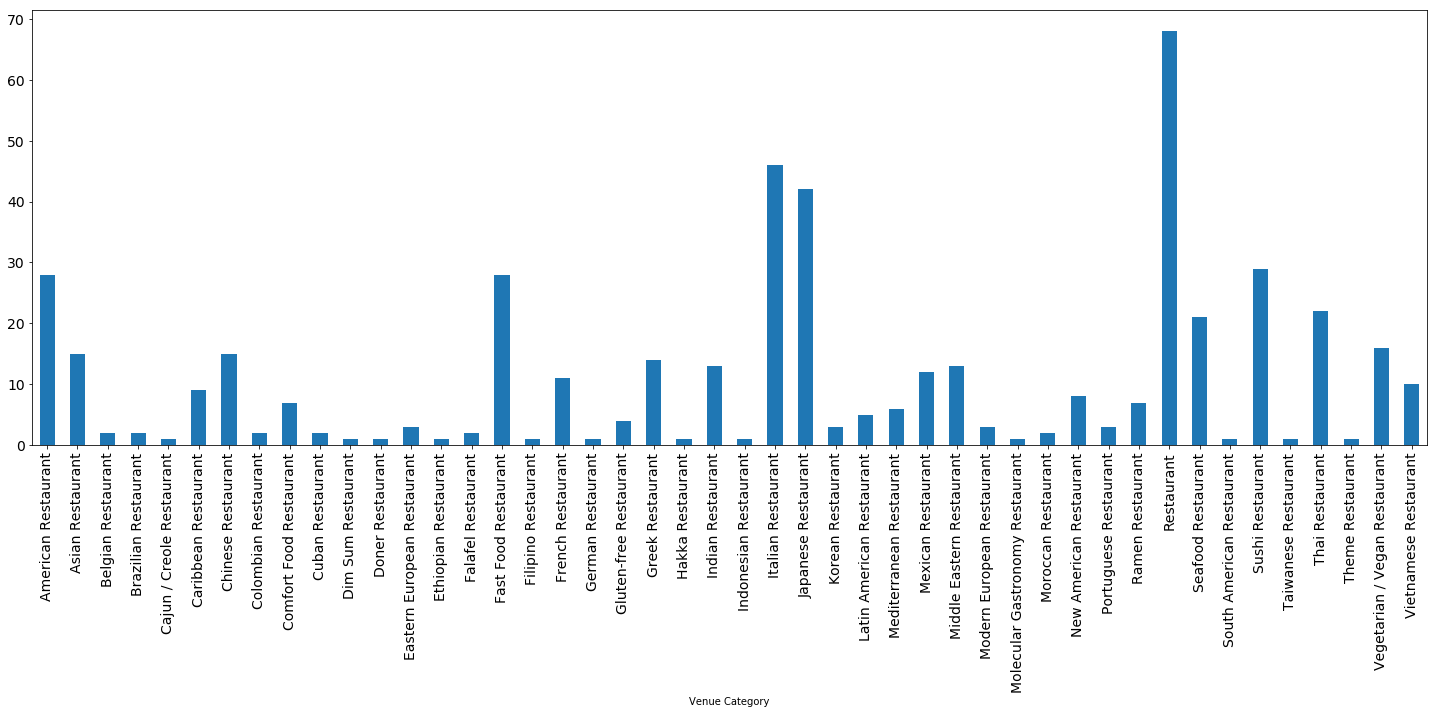

In [108]:
toronto_venues.groupby('Venue Category').size().plot.bar(figsize=(25,8), fontsize = 14)

<H2> 5. Analyze Each Neighborhood

In [37]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']])

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Venue Category_American Restaurant,Venue Category_Asian Restaurant,Venue Category_Belgian Restaurant,Venue Category_Brazilian Restaurant,Venue Category_Cajun / Creole Restaurant,Venue Category_Caribbean Restaurant,Venue Category_Chinese Restaurant,Venue Category_Colombian Restaurant,Venue Category_Comfort Food Restaurant,...,Venue Category_Ramen Restaurant,Venue Category_Restaurant,Venue Category_Seafood Restaurant,Venue Category_South American Restaurant,Venue Category_Sushi Restaurant,Venue Category_Taiwanese Restaurant,Venue Category_Thai Restaurant,Venue Category_Theme Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant
0,Malvern / Rouge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Guildwood / Morningside / West Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Woburn,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Cedarbrae,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Cedarbrae,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<H3> Now, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [38]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Venue Category_American Restaurant,Venue Category_Asian Restaurant,Venue Category_Belgian Restaurant,Venue Category_Brazilian Restaurant,Venue Category_Cajun / Creole Restaurant,Venue Category_Caribbean Restaurant,Venue Category_Chinese Restaurant,Venue Category_Colombian Restaurant,Venue Category_Comfort Food Restaurant,...,Venue Category_Ramen Restaurant,Venue Category_Restaurant,Venue Category_Seafood Restaurant,Venue Category_South American Restaurant,Venue Category_Sushi Restaurant,Venue Category_Taiwanese Restaurant,Venue Category_Thai Restaurant,Venue Category_Theme Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0
1,Bathurst Manor / Wilson Heights / Downsview North,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.000000,...,0.0,0.250000,0.000000,0.0,0.25,0.0,0.000000,0.0,0.000000,0.0
2,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0
3,Bedford Park / Lawrence Manor East,0.1,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.100000,...,0.0,0.200000,0.000000,0.0,0.10,0.0,0.100000,0.0,0.000000,0.0
4,Berczy Park,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.083333,...,0.0,0.166667,0.166667,0.0,0.00,0.0,0.083333,0.0,0.083333,0.0


In [39]:
toronto_grouped.shape

(64, 47)

<H3> Let's print each neighborhood along with the top 5 most common cuisine restaurants

In [40]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['cuisine','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                                    cuisine  freq
0  Venue Category_Latin American Restaurant   1.0
1        Venue Category_American Restaurant   0.0
2    Venue Category_New American Restaurant   0.0
3        Venue Category_Japanese Restaurant   0.0
4          Venue Category_Korean Restaurant   0.0


----Bathurst Manor / Wilson Heights / Downsview North----
                                    cuisine  freq
0         Venue Category_Chinese Restaurant  0.25
1           Venue Category_Sushi Restaurant  0.25
2  Venue Category_Middle Eastern Restaurant  0.25
3                 Venue Category_Restaurant  0.25
4        Venue Category_American Restaurant  0.00


----Bayview Village----
                                    cuisine  freq
0        Venue Category_Japanese Restaurant   0.5
1         Venue Category_Chinese Restaurant   0.5
2      Venue Category_Portuguese Restaurant   0.0
3          Venue Category_Korean Restaurant   0.0
4  Venue Category_Latin American Restaurant   

                                    cuisine  freq
0            Venue Category_Thai Restaurant  0.29
1         Venue Category_Mexican Restaurant  0.29
2  Venue Category_Cajun / Creole Restaurant  0.14
3       Venue Category_Fast Food Restaurant  0.14
4         Venue Category_Italian Restaurant  0.14


----Hillcrest Village----
                                   cuisine  freq
0  Venue Category_Mediterranean Restaurant   1.0
1       Venue Category_American Restaurant   0.0
2   Venue Category_New American Restaurant   0.0
3       Venue Category_Japanese Restaurant   0.0
4         Venue Category_Korean Restaurant   0.0


----India Bazaar / The Beaches West----
                               cuisine  freq
0  Venue Category_Fast Food Restaurant   0.4
1      Venue Category_Sushi Restaurant   0.2
2            Venue Category_Restaurant   0.2
3    Venue Category_Italian Restaurant   0.2
4   Venue Category_American Restaurant   0.0


----Kensington Market / Chinatown / Grange Park----
            

                              cuisine  freq
0     Venue Category_Greek Restaurant  0.50
1   Venue Category_Italian Restaurant  0.19
2           Venue Category_Restaurant  0.06
3    Venue Category_Indian Restaurant  0.06
4  Venue Category_Japanese Restaurant  0.06


----Thorncliffe Park----
                               cuisine  freq
0     Venue Category_Indian Restaurant  0.50
1            Venue Category_Restaurant  0.25
2  Venue Category_Fast Food Restaurant  0.25
3   Venue Category_American Restaurant  0.00
4   Venue Category_Moroccan Restaurant  0.00


----Toronto Dominion Centre / Design Exchange----
                              cuisine  freq
0           Venue Category_Restaurant  0.15
1  Venue Category_Japanese Restaurant  0.15
2  Venue Category_American Restaurant  0.12
3   Venue Category_Seafood Restaurant  0.12
4   Venue Category_Italian Restaurant  0.08


----University of Toronto / Harbord----
                              cuisine  freq
0   Venue Category_Italian Restaurant

<H4> Let's put that into a pandas dataframe

First, let's write a function to sort the cuisine restaurant in descending order.

In [41]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 5 frequent cuisines for each neighborhood.

In [42]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top cuisine
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common cuisine'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common cuisine'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common cuisine,2nd Most Common cuisine,3rd Most Common cuisine,4th Most Common cuisine,5th Most Common cuisine
0,Agincourt,Venue Category_Latin American Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Doner Restaurant,Venue Category_Gluten-free Restaurant,Venue Category_German Restaurant
1,Bathurst Manor / Wilson Heights / Downsview North,Venue Category_Sushi Restaurant,Venue Category_Restaurant,Venue Category_Chinese Restaurant,Venue Category_Middle Eastern Restaurant,Venue Category_Vietnamese Restaurant
2,Bayview Village,Venue Category_Japanese Restaurant,Venue Category_Chinese Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Doner Restaurant,Venue Category_Gluten-free Restaurant
3,Bedford Park / Lawrence Manor East,Venue Category_Restaurant,Venue Category_Italian Restaurant,Venue Category_Indian Restaurant,Venue Category_Comfort Food Restaurant,Venue Category_Greek Restaurant
4,Berczy Park,Venue Category_Restaurant,Venue Category_Seafood Restaurant,Venue Category_Comfort Food Restaurant,Venue Category_French Restaurant,Venue Category_Vegetarian / Vegan Restaurant


<H2> 6. Cluster Neighborhoods

Run k-means to cluster the neighborhood into 10 clusters.

In [43]:
# set number of clusters
kclusters = 10

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([5, 1, 1, 1, 1, 1, 0, 1, 1, 1], dtype=int32)

add clustering labels

In [44]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Let's create a new dataframe that includes the cluster as well as the top 5 frequent cuisine for each neighborhood.

In [45]:
toronto_merged = neighborhoods_venues_sorted
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(df.set_index('Neighborhood'), on='Neighborhood').reset_index()
toronto_merged.tail() # check the last columns!

,index,Cluster Labels,Neighborhood,1st Most Common cuisine,2nd Most Common cuisine,3rd Most Common cuisine,4th Most Common cuisine,5th Most Common cuisine,PostalCode,Borough,Latitude,Longitude
61,60,6,Wexford / Maryvale,Venue Category_Middle Eastern Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Doner Restaurant,Venue Category_Gluten-free Restaurant,Venue Category_German Restaurant,M1R,Scarborough,43.750072,-79.295849
62,61,1,Willowdale,Venue Category_Ramen Restaurant,Venue Category_Sushi Restaurant,Venue Category_Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Middle Eastern Restaurant,M2N,North York,43.770120,-79.408493
63,61,1,Willowdale,Venue Category_Ramen Restaurant,Venue Category_Sushi Restaurant,Venue Category_Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Middle Eastern Restaurant,M2R,North York,43.782736,-79.442259
64,62,8,Woburn,Venue Category_Korean Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Doner Restaurant,Venue Category_Gluten-free Restaurant,Venue Category_German Restaurant,M1G,Scarborough,43.770992,-79.216917
65,63,9,Woodbine Heights,Venue Category_Asian Restaurant,Venue Category_Vietnamese Restaurant,Venue Category_Doner Restaurant,Venue Category_Greek Restaurant,Venue Category_Gluten-free Restaurant,M4C,East York,43.695344,-79.318389


<H3> clusters sizes

In [46]:
toronto_merged.groupby('Cluster Labels').count()['Neighborhood']

Cluster Labels
0     7
1    39
2     3
3     4
4     1
5     1
6     3
7     4
8     1
9     3
Name: Neighborhood, dtype: int64

<H3> Finally, let's visualize the resulting clusters

In [47]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [48]:
toronto_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [49]:
toronto_grouped.tail()

,Cluster Labels,Neighborhood,Venue Category_American Restaurant,Venue Category_Asian Restaurant,Venue Category_Belgian Restaurant,Venue Category_Brazilian Restaurant,Venue Category_Cajun / Creole Restaurant,Venue Category_Caribbean Restaurant,Venue Category_Chinese Restaurant,Venue Category_Colombian Restaurant,...,Venue Category_Ramen Restaurant,Venue Category_Restaurant,Venue Category_Seafood Restaurant,Venue Category_South American Restaurant,Venue Category_Sushi Restaurant,Venue Category_Taiwanese Restaurant,Venue Category_Thai Restaurant,Venue Category_Theme Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant
59,6,Westmount,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,...,0.00,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
60,6,Wexford / Maryvale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
61,1,Willowdale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.25,0.166667,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.083333
62,8,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
63,9,Woodbine Heights,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000


In [50]:
toronto_clusters = toronto_grouped.groupby('Cluster Labels').mean()

In [123]:
toronto_clusters

,Venue Category_American Restaurant,Venue Category_Asian Restaurant,Venue Category_Belgian Restaurant,Venue Category_Brazilian Restaurant,Venue Category_Cajun / Creole Restaurant,Venue Category_Caribbean Restaurant,Venue Category_Chinese Restaurant,Venue Category_Colombian Restaurant,Venue Category_Comfort Food Restaurant,Venue Category_Cuban Restaurant,...,Venue Category_Ramen Restaurant,Venue Category_Restaurant,Venue Category_Seafood Restaurant,Venue Category_South American Restaurant,Venue Category_Sushi Restaurant,Venue Category_Taiwanese Restaurant,Venue Category_Thai Restaurant,Venue Category_Theme Restaurant,Venue Category_Vegetarian / Vegan Restaurant,Venue Category_Vietnamese Restaurant
Cluster Labels,,,,,,,,,,,,,,,,,,,,,
0,0.047619,0.011905,0.000000,0.000000,0.000000,0.000000,0.104762,0.000000,0.000000,0.000000,...,0.000000,0.230952,0.000000,0.000000,0.028571,0.000000,0.00000,0.000000,0.000000,0.000000
1,0.079877,0.016928,0.003089,0.002076,0.003861,0.018741,0.045940,0.002076,0.015412,0.008446,...,0.011778,0.134066,0.029974,0.002457,0.049090,0.002457,0.05212,0.001081,0.029608,0.025725
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.833333,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.083333,0.000000,0.000000,0.458333,0.000000,0.00000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


let's examine each cluster by heatmap

In [51]:
toronto_clusters_trans = toronto_clusters.transpose()
toronto_clusters_trans.head()

Cluster Labels,0,1,2,3,4,5,6,7,8,9
Venue Category_American Restaurant,0.047619,0.079877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Venue Category_Asian Restaurant,0.011905,0.016928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.444444
Venue Category_Belgian Restaurant,0.000000,0.003089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Venue Category_Brazilian Restaurant,0.000000,0.002076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Venue Category_Cajun / Creole Restaurant,0.000000,0.003861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


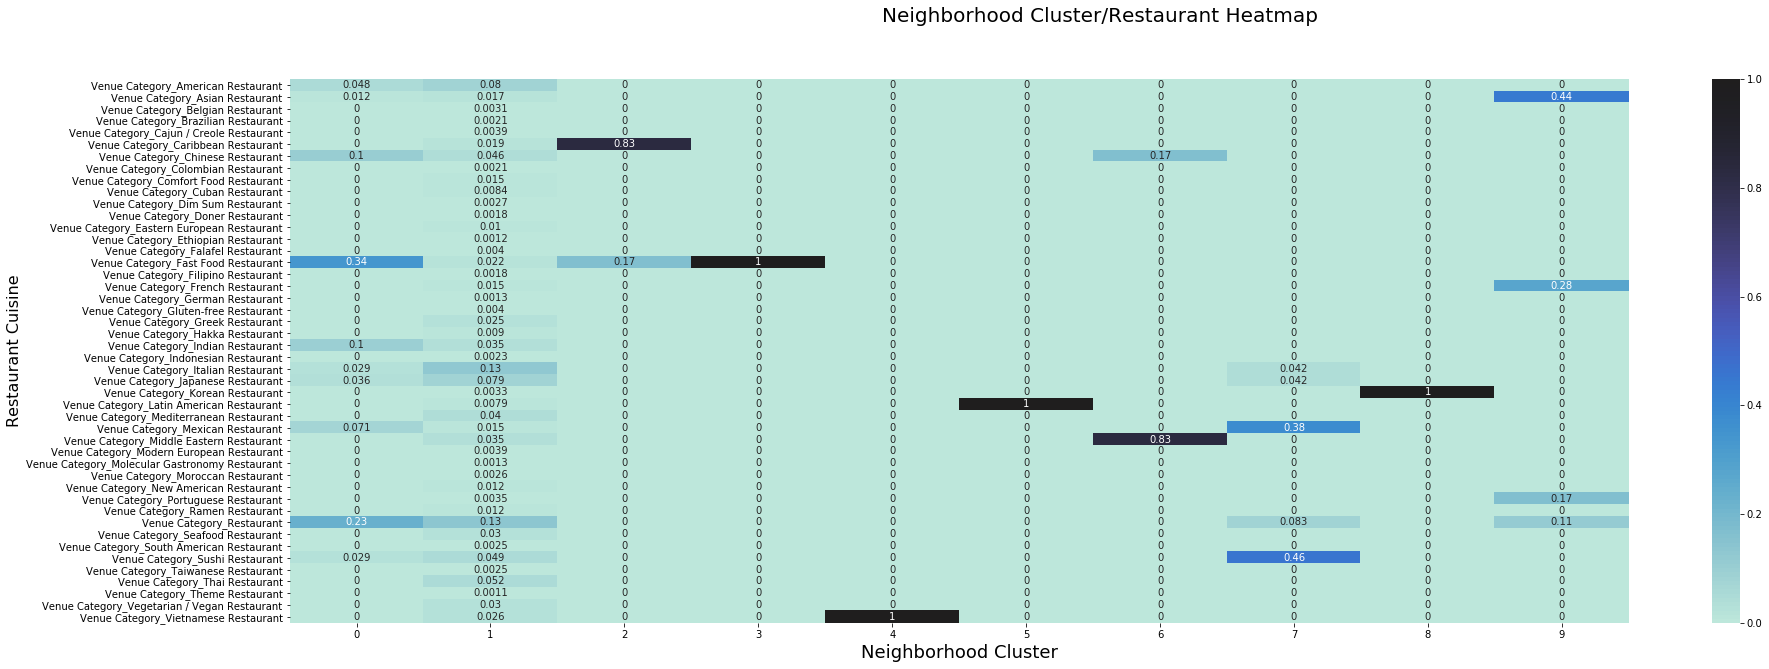

In [52]:
fig, ax = plt.subplots(figsize=(30,10))  
# plot heatmap

ax = sns.heatmap(toronto_clusters_trans, center=1, annot=True, ax=ax)

fig.suptitle('Neighborhood Cluster/Restaurant Heatmap', fontsize=20)
plt.xlabel('Neighborhood Cluster', fontsize=18)
plt.ylabel('Restaurant Cuisine', fontsize=16)
# save figure
plt.show()

<H2> Dark color means that the restaurant cuisine is very common in the corresponding neighborhood cluster, for example if someone is willing to open a new Chinese Restaurant, we can recommend him where not to open his new restaurant.

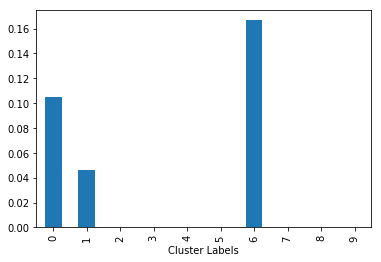

In [53]:
toronto_clusters_trans.loc['Venue Category_Chinese Restaurant'].plot(kind='bar')

<H3> cluster 6,0 & 1 has a high frequent of Chinese restaurants, so try not to open a new chiense restaurant in clusters 6,0 & 1's neighborhoods.